In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb

from functools import partial
from collections import OrderedDict

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
class mlp(nn.Module):
        def __init__(self, input_size, output_size):
            super(mlp, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            
            self.hidden_size = 50
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size,self.hidden_size)
            self.fc3 = torch.nn.Linear(self.hidden_size, self.output_size)
            
            self.relu = torch.nn.ReLU()
            self.sigmoid = torch.nn.Sigmoid() ## sigmoid for multi-label, softmax for multi-class (mutually exclusive)
            
        def forward(self, x):
            out = self.fc1(x)
            out = self.relu(out)
            
            out = self.fc2(out)
            out = self.relu(out)
            
            out = self.fc2(out)
            out = self.relu(out)
            
            out = self.fc2(out)
            out = self.relu(out)
            
            out = self.fc2(out)
            out = self.relu(out)
            
            out = self.fc2(out)
            out = self.relu(out)
            
            out = self.fc3(out)
            out = self.sigmoid(out)
            return out

In [3]:
df = pd.read_csv('data_stephen_fix_header.csv', header=[0])
# convert timecodes to year and month columns
datetimes = pd.to_datetime(df['time'])
df['month'] = datetimes.dt.month
df['year'] = datetimes.dt.year
df['month_cyclic'] = 7 - abs(df['month'] - 7)
print(df.shape[0])
print(df['borehole'].nunique())
df.head()

2837
566


,latitude,longitude,time,borehole,depth,frozen,cryostructures,visible_ice,ASTM_2488,materials,organic_cover,top_of_interval,bottom_of_interval,month,year,month_cyclic
0,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.15,0,NaN,NaN,TOPSOIL,Organics,0.3,0.0,0.3,3,2012,3
1,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,0.85,1,NaN,Pure ice,ICE,Ice,0.3,0.3,1.4,3,2012,3
2,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,1.90,1,Nf,No visible ice,SW-SM,Coarse till,0.3,1.4,2.4,3,2012,3
3,69.16162,-133.08682,2012-03-21T00:00:00Z,0170-1-10,5.40,1,Nf,No visible ice,GW-GM,Coarse till,0.3,2.4,8.4,3,2012,3
4,69.16105,-133.08880,2012-03-21T00:00:00Z,0170-1-12,1.20,1,Nf,No visible ice,GP-GM,Coarse till,0.0,0.0,2.4,3,2012,3


[3 4 2]


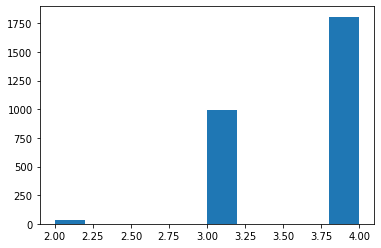

In [4]:
print(df['month'].unique())
b = plt.hist(df['month'].values)

[2012 2014 2013 2017]


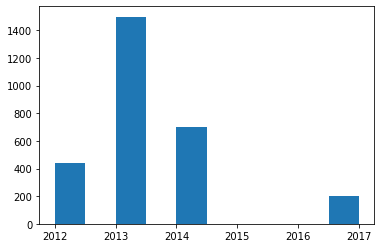

In [5]:
print(df.year.unique())
b = plt.hist(df.year.values)

In [6]:
class boreholeDataset(Dataset):
    def __init__(self, data_root, df):
        
        self.df = df
        
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        #surface = torch.tensor(row.filter(['latitude', 'longitude', 'year', 'month', 'depth'])).float()
        surface = torch.tensor(row.filter(['depth', 'month'])).float()
        
        frozen = torch.tensor(row.at['frozen']).float()
        
        return {'surface_data': surface, 'frozen': frozen}

In [7]:
full_dataset = boreholeDataset("geomorph_data", df)

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

training_data, test_data = torch.utils.data.random_split(full_dataset, [train_size, test_size])

batchsize = 20

trainloader = DataLoader(training_data, batch_size=batchsize, shuffle=True)
testloader = DataLoader(test_data, batch_size=batchsize, shuffle=True)

In [8]:
input_size = list(full_dataset[0]['surface_data'].size())
surface_model = mlp(input_size[0],1)

optimizer = torch.optim.Adam(surface_model.parameters())

# loss_fn = nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss() # binary cross entropy

surface_model.train()
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # loop over each sample
        
        # get the inputs; data is a list of [inputs, labels]
        surface_data, labels = data['surface_data'], data['frozen']
        
#         print(surface_data)
#         print(labels)
#         break;
        predicted = surface_model(surface_data)
        
        #print(predicted.squeeze().shape)
        #print(labels.shape)

        loss = loss_fn(predicted.squeeze(), labels)

        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        # print statistics
        print_interval = 50
        running_loss += loss.item()
        if i % print_interval == print_interval-1:    # print every $print_interval mini-batches
            print('[%d, %5d] running loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / print_interval))
            running_loss = 0.0

print('Finished Training')

[1,    50] running loss: 0.47315
[1,   100] running loss: 0.26972
[2,    50] running loss: 0.21882
[2,   100] running loss: 0.18287
[3,    50] running loss: 0.14980
[3,   100] running loss: 0.16434
[4,    50] running loss: 0.18648
[4,   100] running loss: 0.12794
[5,    50] running loss: 0.11355
[5,   100] running loss: 0.18536
[6,    50] running loss: 0.12270
[6,   100] running loss: 0.15788
[7,    50] running loss: 0.16154
[7,   100] running loss: 0.12481
[8,    50] running loss: 0.12594
[8,   100] running loss: 0.15145
[9,    50] running loss: 0.15459
[9,   100] running loss: 0.12929
[10,    50] running loss: 0.12865
[10,   100] running loss: 0.12766
Finished Training


In [9]:
surface_model.eval()
with torch.no_grad():
    y_test = []
    y_pred = []
    for i, data in enumerate(testloader, 0):
        surface_data, label = data['surface_data'], data['frozen']

        # y_test.append(label.numpy().list())
        # print(label.shape)
        # print(images.shape)
        output = surface_model(surface_data)
        predicted = torch.round(output)
        # print(predicted.shape)
        lb = label.tolist()
        pd = predicted.tolist()
        y_test.extend(lb)
        y_pred.extend(pd)
    

In [10]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[ 59  17]
 [ 10 482]]
              precision    recall  f1-score   support

         0.0       0.86      0.78      0.81        76
         1.0       0.97      0.98      0.97       492

    accuracy                           0.95       568
   macro avg       0.91      0.88      0.89       568
weighted avg       0.95      0.95      0.95       568

0.9524647887323944


In [11]:
full_dataset[0]

{'surface_data': tensor([0.1500, 3.0000]), 'frozen': tensor(0.)}